# Imports and Color Set

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import cpi
import tol_colors as tc
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns
import os

In [2]:
plt.figure(figsize=(13,13))
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20
cset = tc.tol_cset('bright')

<Figure size 936x936 with 0 Axes>

## Importing and merging EIA form 861 data

In [6]:
path = "../datafiles/Merged EIA data - all CA utilities.csv"

if os.path.isfile(path):
    all_eia = pd.read_csv(path)
else:
    #Iterate over EIA 861 tables from 2014-2022
    yrs = list(range(2014,2023))
    yr_dfs=[]
    for yr in yrs:
        #Load in a file
        file = 'Sales_Ult_Cust_'+str(yr)+'.xlsx'
        df=pd.read_excel('../datafiles/EIA Data/'+file,sheet_name="States",header=2)

        #Keep only California IOUs, MOUs, CCAs
        df=df[((df['Ownership']=='Community Choice Aggregator') | (df['Ownership']=='Municipal') | (df['Ownership']=='Political Subdivision') |(df['Ownership']=='Investor Owned') |  (df['Utility Name']=='Southern California Edison Co')) & (df['State']=='CA')]

        #Rename ownership to abbreviation
        df['Ownership'] = df['Ownership'].map({'Investor Owned': 'IOU',
                                               'Community Choice Aggregator': 'CCA',
                                               'Municipal':'POU',
                                               'Political Subdivision':'POU'
                                              })


        #Only keep useful columns, and make them integers
        df=df[['Data Year', 'Utility Name','Service Type','Ownership','Thousand Dollars.1','Megawatthours.1','Count.1','Thousand Dollars.2','Megawatthours.2','Count.2','Thousand Dollars','Megawatthours','Count']]
        cols = ['Thousand Dollars.1','Megawatthours.1','Count.1','Thousand Dollars.2','Megawatthours.2','Count.2','Thousand Dollars','Megawatthours','Count']
        df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0)

        #Rename columns to make sense
        df=df.rename(columns={"Data Year": "Year", 
                              "Thousand Dollars": "Revenue (thousand$)_res",'Megawatthours':'Sales (MWh)_res','Count':'Customers_res',
                             "Thousand Dollars.1": "Revenue (thousand$)_com",'Megawatthours.1':'Sales (MWh)_com','Count.1':'Customers_com',
                             "Thousand Dollars.2": "Revenue (thousand$)_ind",'Megawatthours.2':'Sales (MWh)_ind','Count.2':'Customers_ind'})

        #Ensure everything is in integer form
        df.astype({"Revenue (thousand$)_res":'int32','Sales (MWh)_res':'int32','Customers_res':'int32',
                              "Revenue (thousand$)_com":'int32','Sales (MWh)_com':'int32','Customers_com':'int32',
                              "Revenue (thousand$)_com":'int32','Sales (MWh)_com':'int32','Customers_ind':'int32'})



        #Keep only 3 chosen utilities
        #df['Utility Name'] = df['Utility Name'].str.replace('.', '',regex=False)
        #df=df[(df['Utility Name']=='Southern California Edison Co')|(df['Utility Name']=='Pacific Gas & Electric Co')|(df['Utility Name']=='San Diego Gas & Electric Co')
        #     | (df['Utility Name']=='Los Angeles Department of Water & Power')|(df['Utility Name']=='Sacramento Municipal Util Dist')|(df['Utility Name']=='Imperial Irrigation District')
        #     |(df['Utility Name']=='Marin Clean Energy')|(df['Utility Name']=='East Bay Community Energy')|(df['Utility Name']=='Clean Power Alliance of Southern Califor')]    

        df.reset_index(drop=True,inplace=True)
        yr_dfs.append(df)

    #Merge all EIA into a single form and output to CSV
    all_eia = pd.concat(yr_dfs)
    all_eia.to_csv(path)

## Time series of POU, IOU bundled customers vs. CCA energy customers

ValueError: x and y must have same first dimension, but have shapes (9,) and (16,)

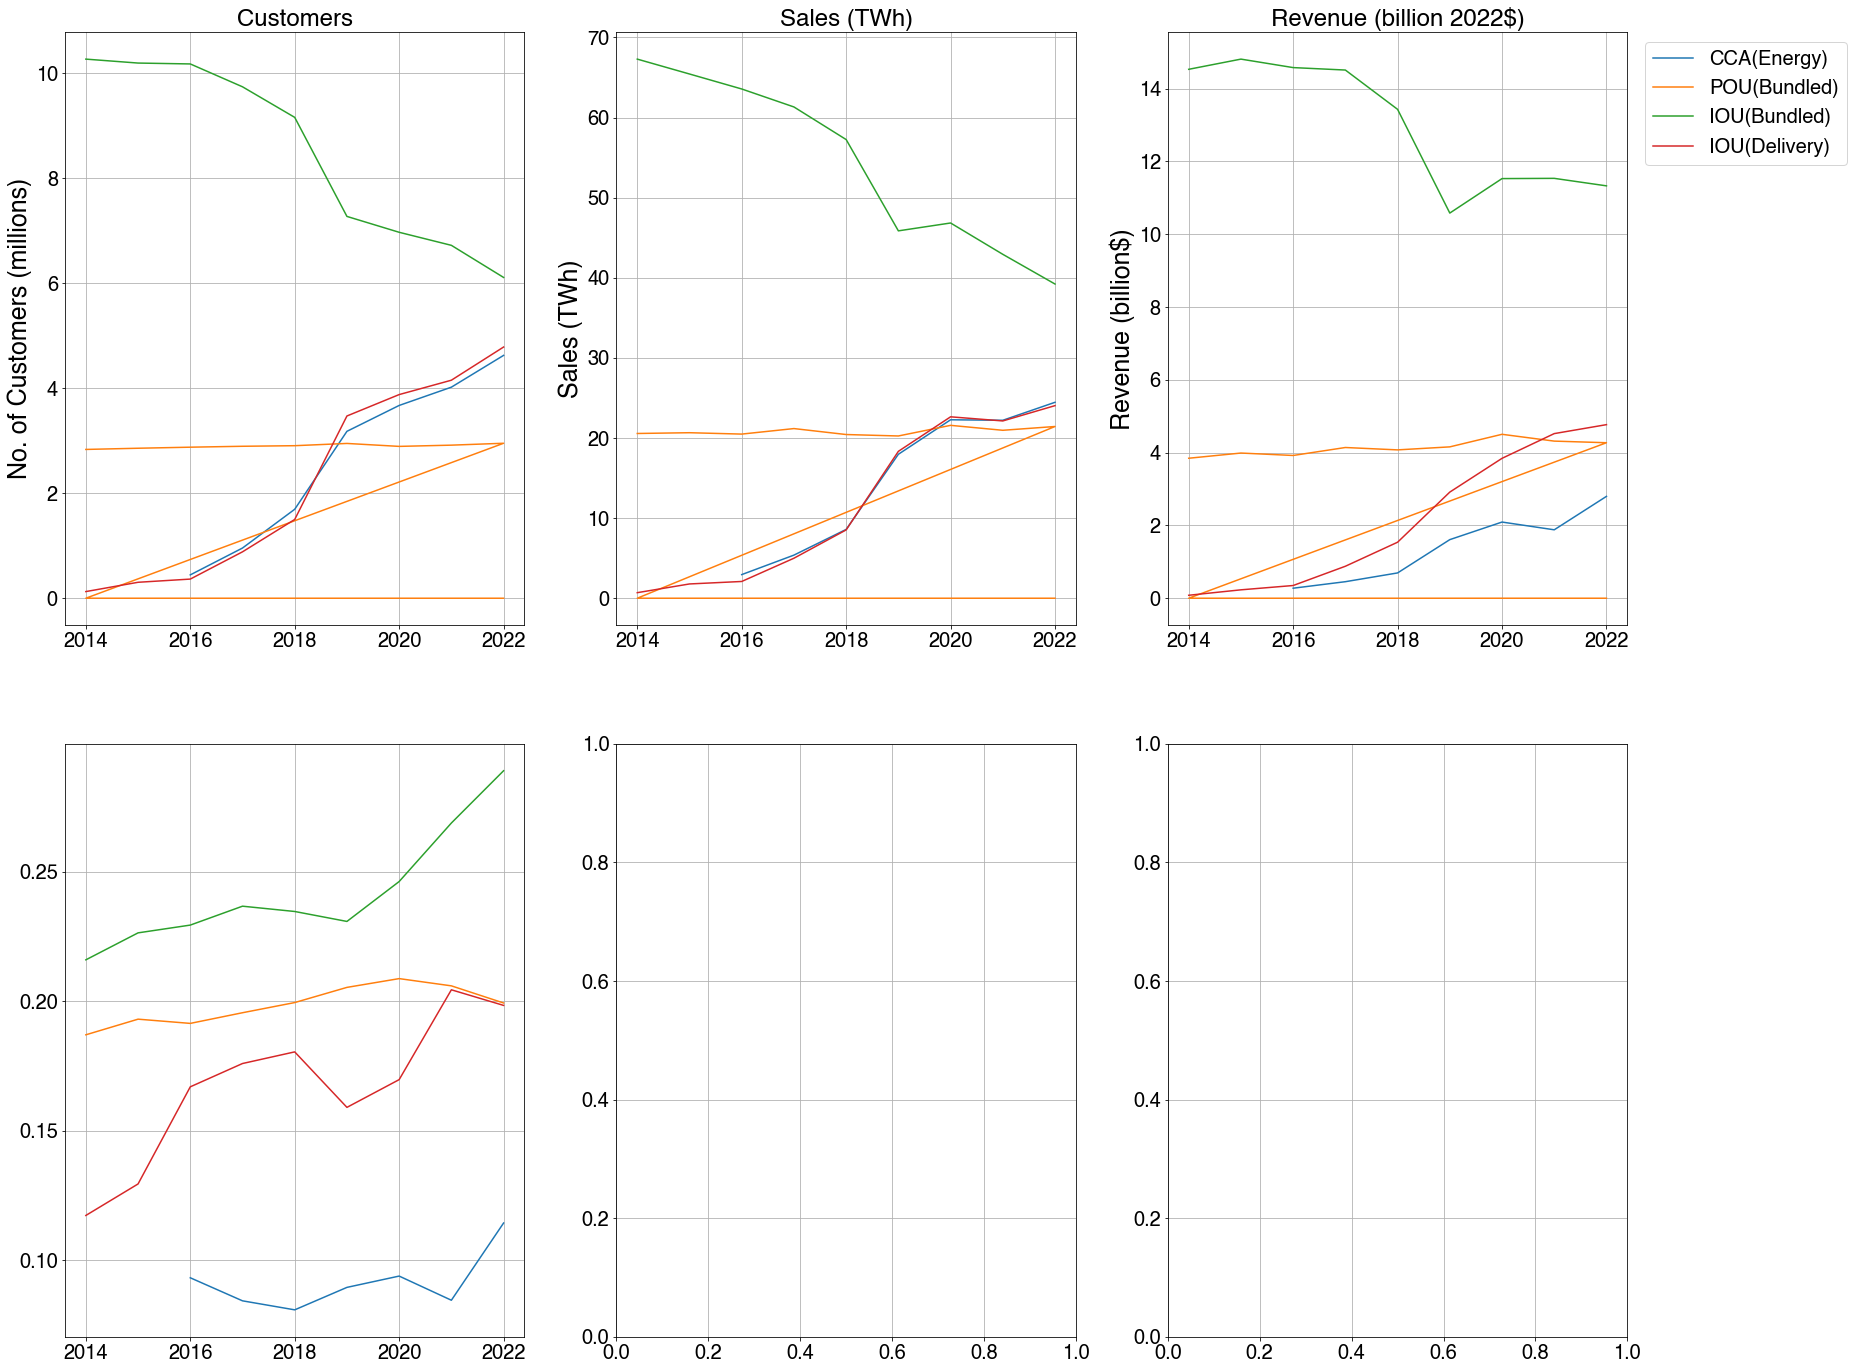

In [8]:
grouped_eia = all_eia.groupby(['Ownership','Service Type','Year']).agg('sum').reset_index(drop=False)
grouped_eia["real_Revenue (thousand$)_res"] = grouped_eia.apply(
    lambda x: cpi.inflate(x['Revenue (thousand$)_res'], x['Year']), axis=1
)

cca_energy = grouped_eia[grouped_eia['Ownership']=='CCA']
pou_bundled = grouped_eia[grouped_eia['Ownership']=='POU']
iou_bundled = grouped_eia[(grouped_eia['Ownership']=='IOU')&(grouped_eia['Service Type']=='Bundled')]
iou_delivery = grouped_eia[(grouped_eia['Ownership']=='IOU')&(grouped_eia['Service Type']=='Delivery')]
cca_bundled = 

fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(28,24))
for ax in axs.flatten():
    ax.grid(visible=True)

axs[0,0].plot(cca_energy['Year'],cca_energy['Customers_res']/1e6,label='CCA(Energy)')
axs[0,0].plot(pou_bundled['Year'],pou_bundled['Customers_res']/1e6,label='POU(Bundled)')
axs[0,0].plot(iou_bundled['Year'],iou_bundled['Customers_res']/1e6,label='IOU(Bundled)')
axs[0,0].plot(iou_delivery['Year'],iou_delivery['Customers_res']/1e6,label='IOU(Delivery)')

axs[0,0].legend(loc='upper right',bbox_to_anchor=(3.9,1))
#axs[0,0].set_xlabel('Year')

axs[0,0].set_ylabel('No. of Customers (millions)')
axs[0,0].set_title('Customers')


axs[0,1].plot(cca_energy['Year'],cca_energy['Sales (MWh)_res']/1e6,label='CCA(Energy)')
axs[0,1].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_res']/1e6,label='POU(Bundled)')
axs[0,1].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_res']/1e6,label='IOU(Bundled)')
axs[0,1].plot(iou_delivery['Year'],iou_delivery['Sales (MWh)_res']/1e6,label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[1,0].set_xlabel('Year')
axs[0,1].set_ylabel('Sales (TWh)')
axs[0,1].set_title('Sales (TWh)')


axs[0,2].plot(cca_energy['Year'],cca_energy['real_Revenue (thousand$)_res']/1e6,label='CCA(Energy)')
axs[0,2].plot(pou_bundled['Year'],pou_bundled['real_Revenue (thousand$)_res']/1e6,label='POU(Bundled)')
axs[0,2].plot(iou_bundled['Year'],iou_bundled['real_Revenue (thousand$)_res']/1e6,label='IOU(Bundled)')
axs[0,2].plot(iou_delivery['Year'],iou_delivery['real_Revenue (thousand$)_res']/1e6,label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[0,2].set_ylabel('Revenue (billion$)')
axs[0,2].set_title('Revenue (billion 2022$)')

axs[1,0].plot(cca_energy['Year'],(cca_energy['real_Revenue (thousand$)_res']/1e6)/(cca_energy['Sales (MWh)_res']/1e6),label='CCA(Energy)')
axs[1,0].plot(pou_bundled['Year'],(pou_bundled['real_Revenue (thousand$)_res']/1e6)/(pou_bundled['Sales (MWh)_res']/1e6),label='POU(Bundled)')
axs[1,0].plot(iou_bundled['Year'],(iou_bundled['real_Revenue (thousand$)_res']/1e6)/(iou_bundled['Sales (MWh)_res']/1e6),label='IOU(Bundled)')
axs[1,0].plot(iou_delivery['Year'],(iou_delivery['real_Revenue (thousand$)_res']/1e6)/(iou_delivery['Sales (MWh)_res']/1e6),label='IOU(Delivery)')

axs[1,0].plot(iou_delivery['Year'],(iou_delivery['real_Revenue (thousand$)_res']/1e6)/(iou_delivery['Sales (MWh)_res']/1e6)+(cca_energy['real_Revenue (thousand$)_res']/1e6)/(cca_energy['Sales (MWh)_res']/1e6),label='IOU(Delivery)+CCA(Energy)')


#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[1,0].set_ylabel('Avg price(2022$/kWh)')
axs[1,0].set_title('Avg price(2022$/kWh)')

axs[1,1].plot(cca_energy['Year'],cca_energy['Sales (MWh)_res']/cca_energy['Customers_res'],label='CCA(Energy)')
axs[1,1].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_res']/pou_bundled['Customers_res'],label='POU(Bundled)')
axs[1,1].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_res']/iou_bundled['Customers_res'],label='IOU(Bundled)')
axs[1,1].plot(iou_delivery['Year'],iou_delivery['Sales (MWh)_res']/iou_delivery['Customers_res'],label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[1,1].set_ylabel('Avg Energy (MWh per year/customer)')
axs[1,1].set_title('Energy Usage (MWh per year/customer)')

axs[1,2].plot(cca_energy['Year'],1e3*cca_energy['real_Revenue (thousand$)_res']/cca_energy['Customers_res'],label='CCA(Energy)')
axs[1,2].plot(pou_bundled['Year'],1e3*pou_bundled['real_Revenue (thousand$)_res']/pou_bundled['Customers_res'],label='POU(Bundled)')
axs[1,2].plot(iou_bundled['Year'],1e3*iou_bundled['real_Revenue (thousand$)_res']/iou_bundled['Customers_res'],label='IOU(Bundled)')
axs[1,2].plot(iou_delivery['Year'],1e3*iou_delivery['real_Revenue (thousand$)_res']/iou_delivery['Customers_res'],label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[1,2].set_ylabel('Avg Revenue per Customer(2022$/cust)')
axs[1,2].set_title('Avg Revenue per Customer (2022$/cust)')


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Year")
#plt.ylabel("common Y")
plt.suptitle("California All Residential Customers - Timeseries Profile",fontsize=44,y=0.95)
fig
#fig.savefig('Timeseries of ALL Residential Customers.png',dpi=600,bbox_inches='tight')